In [5]:
import pandas as pd
import numpy as np

from class_ARIMA import ARIMA_container

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

### DataFrame for simple analysis and projection

The code below throws away a considerable portion of data presented in the dataset. The aim of preparing such DataFrame is for simplifying our variables and utilize single variable projection methods such as linear, polinomial or SVR regression models from scikit-learn.

In [6]:
# Specify the columns to keep
simple_cols = ['LocID', 'Time', 'TPopulation1Jan', 'PopChange', 'PopGrowthRate', 'DoublingTime']

# Read the data and keep only the required columns
simple_raw_data = pd.read_parquet('raw_data.parquet')[simple_cols]

# Filter data for LocID == 840 (aka. USA)
simple_data_usa = simple_raw_data[simple_raw_data['LocID'] == 840].copy()

# Convert data types
simple_data_usa['LocID'] = simple_data_usa['LocID'].astype('int16')
simple_data_usa['Time'] = pd.to_datetime(simple_data_usa['Time'], format='%Y')

# Display memory usage information
simple_data_usa.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 39064 to 39215
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   LocID            152 non-null    int16         
 1   Time             152 non-null    datetime64[ns]
 2   TPopulation1Jan  152 non-null    float64       
 3   PopChange        151 non-null    float64       
 4   PopGrowthRate    151 non-null    float64       
 5   DoublingTime     74 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int16(1)
memory usage: 7.4 KB


### Autoregressive Integrated Moving Average (ARIMA) Model

Below, you can find a ARIMA model trained in its own container. This model is configured by use of the order parameter (see class_ARIMA docs) to mimic the UN projections as closely as possible. While such a training method is significantly more prone to overfitting issues, the dataa we are fitting to is already a well trained and complex neural network developed by the United Nations. By utilizing an established and extensive model as the target of our overfitting, we aim to provide similar results to UN projections for a fraction of the computing power and runtime.

Wihle the plot below confirms that our model is producing a simplified version of UN predictions, we can numerically check the rate of similarity by exploring the $R^2$ (coefficient of determination) value. ($R^2 = 1$ means idetical curves.) 

$R^2$ value is calculated by the formula: $$ R^2 = 1 - \frac{RSS}{TSS} $$ where RSS is the sum of squares of residuals and TSS is the total sum of squares. 
The determination coefficient for ARIMA vs UN then becomes $R^2_{ARIMA \space / \space UN} \approx 0.986578$ 

R2 = 0.9865778191404624


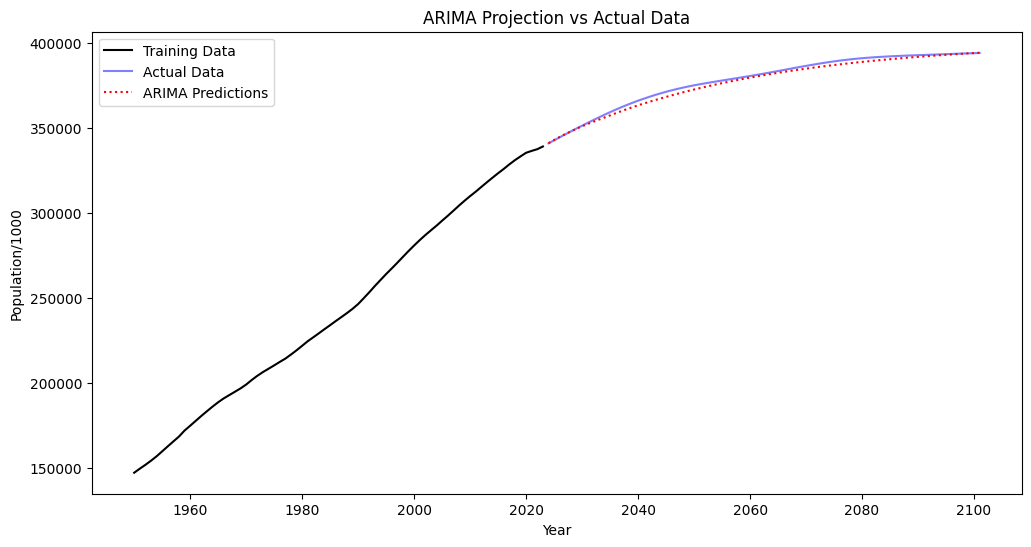

In [7]:
# Fit data and make projections with ARIMA
ARIMA = ARIMA_container(simple_data_usa, order=(13,1,0))
ARIMA.estimate()

# Calculate R2 value
print(f'R2 = {r2_score(ARIMA.predictions.values, ARIMA.control_data["TPopulation1Jan"].values)}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(ARIMA.training_data.index, ARIMA.training_data['TPopulation1Jan'], label='Training Data', color='black')
plt.plot(ARIMA.control_data.index, ARIMA.control_data['TPopulation1Jan'], label='Actual Data', color='blue', alpha=0.5)
plt.plot(ARIMA.predictions.index, ARIMA.predictions.values, label='ARIMA Predictions', color='red', linestyle='dotted')
plt.legend()
plt.title('ARIMA Projection vs Actual Data')
plt.xlabel('Year')
plt.ylabel('Population/1000')
plt.show()

### DataFrame for complex analysis and projection

The DataFrame configured below holds all data that can be used by a prediction model and strips other columns such as area classifications, names and notes which are not relevant for prediction. This helps create a more robust projection through model such as decision tree wich can utilize relationships and ratios between pieces of dependant data to reach an acceptable projection.

In [8]:
# Specify columns to drop
complex_drop_cols = ['SortOrder', 'Notes', 'ISO3_code', 'ISO2_code', 'SDMX_code', 'LocTypeID', 'LocTypeName', 'ParentID', 'Location', 'VarID', 'Variant']
# Read data and drop specified columns
complex_raw_data = pd.read_parquet('raw_data.parquet')
complex_raw_data = complex_raw_data.drop(columns=complex_drop_cols)

# Filter data for LocID == 840 (aka. USA)
complex_data_usa = complex_raw_data[complex_raw_data['LocID'] == 840].copy()

# Convert data types
complex_data_usa['LocID'] = complex_data_usa['LocID'].astype('int16')
complex_data_usa['Time'] = pd.to_datetime(complex_data_usa['Time'], format='%Y')

# Display memory usage information
complex_data_usa.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 39064 to 39215
Data columns (total 56 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   LocID                   152 non-null    int16         
 1   Time                    152 non-null    datetime64[ns]
 2   TPopulation1Jan         152 non-null    float64       
 3   TPopulation1July        151 non-null    float64       
 4   TPopulationMale1July    151 non-null    float64       
 5   TPopulationFemale1July  151 non-null    float64       
 6   PopDensity              151 non-null    float64       
 7   PopSexRatio             151 non-null    float64       
 8   MedianAgePop            151 non-null    float64       
 9   NatChange               151 non-null    float64       
 10  NatChangeRT             151 non-null    float64       
 11  PopChange               151 non-null    float64       
 12  PopGrowthRate           151 non-null    floa

In [12]:
type(ARIMA.training_data)

pandas.core.frame.DataFrame